In [2]:
import numpy as np
from matplotlib.pyplot import subplots, show, close
from spectrapepper import alsbaseline

In [256]:
raw = np.loadtxt('Arcturus_stack.txt')
data = alsbaseline(raw, lam=50, remove=False)
drm = alsbaseline(raw, lam=500)

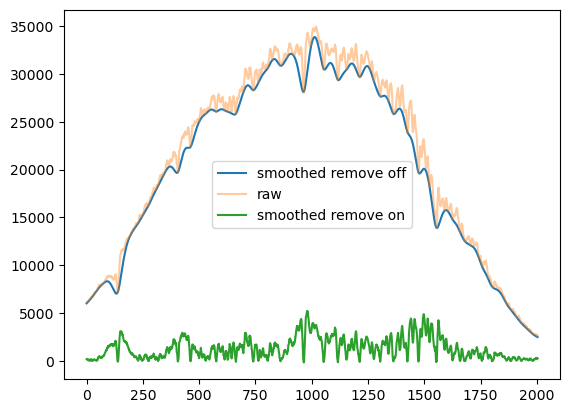

In [257]:
%matplotlib inline
fig, ax = subplots()
ax.plot(data, label='smoothed remove off')
ax.plot(raw, label='raw', alpha=0.4)
ax.plot(drm, label='smoothed remove on')
ax.legend()
show()
close(fig)

In [10]:
def deriv(data: list, iterations: int=1):
    if not isinstance(iterations, int):
        raise ValueError('iterations should be integer value')
    
    out = []
    out.append((data[1] - data[0]))
    for i in range(1, len(data)-1):
        area_slope = ((data[i+1] - data[i]) + (data[i] - data[i-1]))/2
        out.append(area_slope)
    out.append((data[-1] - data[-2]))
    iterations -= 1
    if iterations > 0:
        out = deriv(out, iterations)
    return np.array(out)
def get_peak_locations(data, edge_padding=1):
    array = data.copy()
    sectors = get_peak_sectors(array)
    peaks = []
    for left, right in sectors:
        min, max = None, None
        argmax = array[left:right].argmax() + left
        argmin = array[left:right].argmin() + left
        if not (argmin <= left + edge_padding or argmin >= right - edge_padding):
            valmin = array[left:right].min()
            min = (argmin, valmin)
            peaks.append(min)
        if not (argmax <= left + edge_padding or argmax >= right - edge_padding):
            valmax = array[left:right].max()
            max = (argmax, valmax)
            peaks.append(max)
        del argmax, argmin, min, max
    # print(peaks)
    return peaks
def get_peak_sectors(array):
    was_nan = True
    start = 0
    sectors = []
    for i, element in enumerate(array):
        is_nan = np.isnan(element)
        if not is_nan and was_nan:
            was_nan = False
            start = i
        elif is_nan and not was_nan:
            was_nan = True
            sectors.append([start, i]) # SHOULD PROBABLY BE i+1 BUT BREAKS CODE
            del start
    if not was_nan:
        sectors.append([start, len(array)])
    return sectors
def exclude(data, value, baseline=0, invert=False):
    dat = data.copy()
    value = np.abs(value)
    if not invert:
        excluded_array = np.where(np.abs(dat) < (baseline+value), np.nan, dat)
    else:
        excluded_array = np.where(np.abs(dat) > (baseline+value), np.nan, dat)
    # print(dat, baseline+value, excluded_array)
    return excluded_array


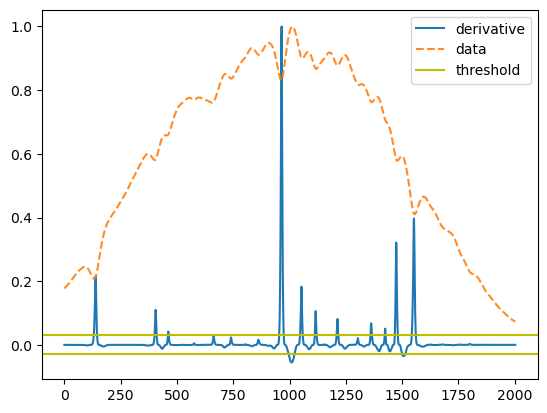

In [259]:
%matplotlib inline

threshold = 0.03
d = deriv(data, 2)
data /= data.max()

adj = d ** 3
adj /= adj.max()

fig, ax = subplots()
ax.plot(adj, label='derivative')
ax.plot(data, alpha=0.9, linestyle='--', label='data')
ax.axhline(y=threshold, color='y', label='threshold')
ax.axhline(y=-threshold, color='y')
ax.legend()
show()

In [260]:
raw = np.loadtxt('Arcturus_stack.txt')

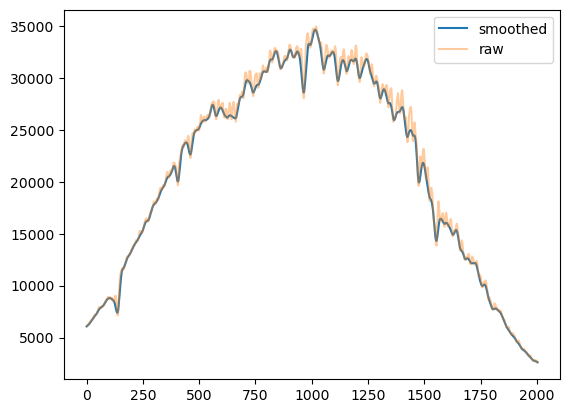

In [261]:
%matplotlib inline

data = alsbaseline(raw, lam=100, remove=False, niter=2)

fig, ax = subplots()
ax.plot(data, label='smoothed')
ax.plot(raw, label='raw', alpha=0.4)
ax.legend()
show()
# close(fig)

In [263]:
d = deriv(data, 2)
adj =  d**3
if np.abs(adj.max()) > np.abs(adj.min()):
    adj /= adj.max()
else:
    adj /= adj.min()

threshold = np.percentile(adj, 4)

print(threshold)
adj_exl = exclude(adj, threshold)

# fig, ax = subplots()
# ax.plot(adj, label='derivative', linestyle='--', alpha=0.4)
# ax.plot(adj_exl, label='excluded derivative', alpha=0.8)
# ax.axhline(y=threshold, color='y', label='threshold')
# ax.axhline(y=-threshold, color='y')
# ax.legend()
# show()

-0.025964683790188414


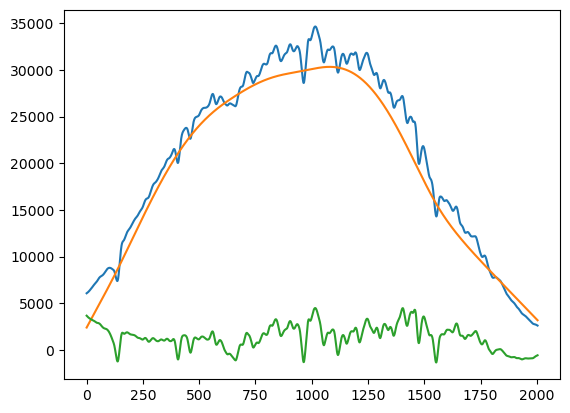

In [264]:
smooth_data = alsbaseline(data, lam=5e5, niter=70, remove=False)+1000
sub = (data-smooth_data)


fig, ax = subplots()
ax.plot(data)
ax.plot(smooth_data)
ax.plot(data-smooth_data)
show()

In [265]:
%matplotlib qt

"""
TODO: 
    QOL: Make slider for threshold, exponent of adjustment, peak padding
    FEAT: Absorbtion and Emission datastructures for matching spectroscopic data to known peaks
    
thoughts:
    maybe doing a median/mean between supersmooth and normalsmooth data difference can get a better fit?
    use this better fit to get good relative intensities from data using found peak coordinates.
    use relative peak position and intensities to match against known spectra 
"""


fig, ax = subplots()
d = deriv(sub, 2)
adj = d**3
if np.abs(adj.max()) > np.abs(adj.min()):
    adj /= adj.max()
else:
    adj /= adj.min()

threshold = np.percentile(adj, 1.5)
adj_exl = exclude(adj, threshold)

ax.step(np.arange(adj_exl.size), adj_exl, label='included derivative', color='b', alpha=0.4)
# ax.step(np.arange(adj.size), exclude(adj, threshold, invert=True), label='excluded derivative', color='b', linestyle='--', alpha=0.8)
ax.plot((0.5*raw/raw.max())**2, alpha=0.4, label='raw data', color='red', linewidth=1.2)
ax.plot((0.5*data/data.max())**2, alpha=0.4, label='smooth data', color='k', linewidth=1.2)
# ax.step(np.arange(adj_exl.size), adj_exl, label='excluded derivative', alpha=0.8)
label = False
for x, y in get_peak_locations(adj_exl):
    if not label:
        ax.scatter(x, y, color='r', alpha=0.6, marker='+', label='peaks')
        label = True
    else:
        ax.scatter(x, y, color='r', alpha=0.6, marker='+')
ax.set_title('Arcturus peak finding graph')
ax.axhline(threshold, color='y', alpha=0.3, label='threshold')
ax.axhline(-threshold, color='y', alpha=0.3)
fig.legend()

show()


In [266]:
%matplotlib qt

d = deriv(data, 2)
data /= data.max()

most_intense = None

adj = d ** 3



if np.abs(adj.max()) > np.abs(adj.min()):
    adj /= adj.max()
    threshold = np.percentile(adj, 2)
    most_intense = 'Absorbtion', 'Emmision'
else:
    adj /= adj.min()
    threshold = np.percentile(adj, 2)
    most_intense = 'Emmision', 'Absorbtion'



fig, ax = subplots()
fig.suptitle(f'derivative peaks show {most_intense[0]} lines, valleys show {most_intense[1]} lines')
ax.plot(adj, label='derivative')
ax.plot(data, alpha=0.9, linestyle='--', label='data')
ax.axhline(y=threshold, color='y', label='threshold')
ax.axhline(y=-threshold, color='y')
ax.legend()
show()

In [267]:
raw = np.loadtxt('calibration.txt')

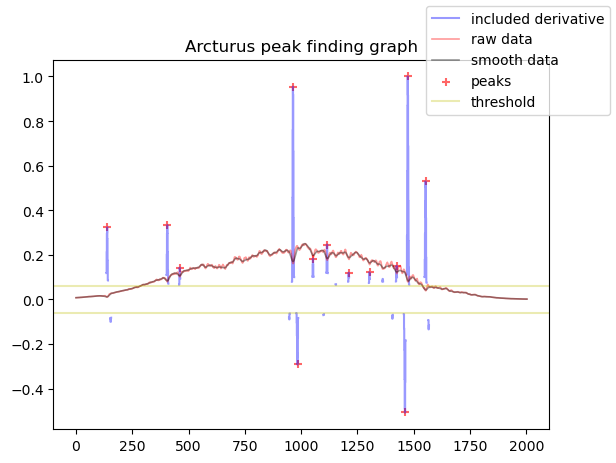

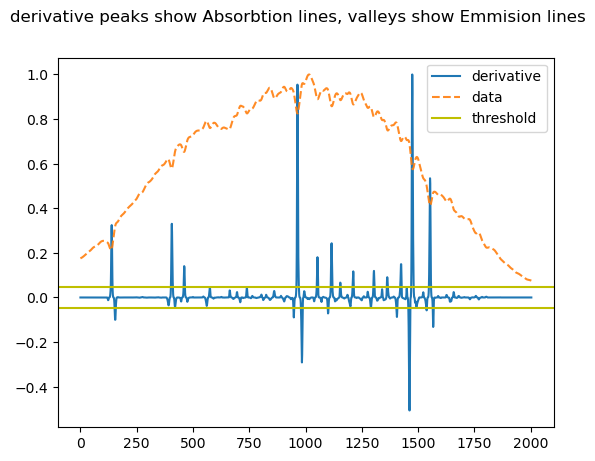

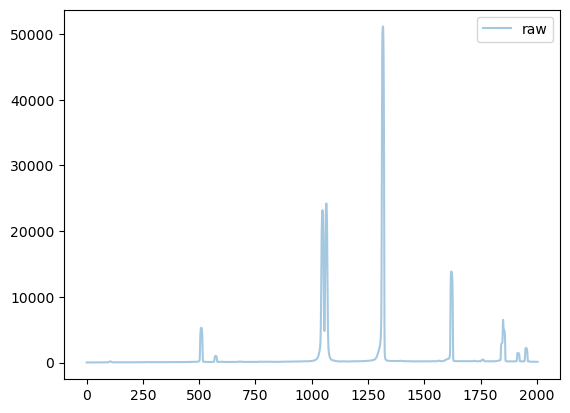

In [268]:
%matplotlib inline
data = raw #alsbaseline(raw, lam=100, remove=False, niter=2)

fig, ax = subplots()
# ax.plot(data, label='smoothed')
ax.plot(raw, label='raw', alpha=0.4)
ax.legend()
show()

In [269]:
derivative = deriv(data, 2)
derivative_adjusted = derivative
# derivative_adjusted = raw

if np.abs(derivative_adjusted.max()) > np.abs(derivative_adjusted.min()):
    derivative_adjusted /= derivative_adjusted.max()
else:
    derivative_adjusted /= derivative_adjusted.min()

threshold = np.percentile(derivative_adjusted, 3)
excluded_data = exclude(derivative_adjusted, threshold)

peaks = get_peak_locations(excluded_data)
# get_peak_locations(excluded_data)

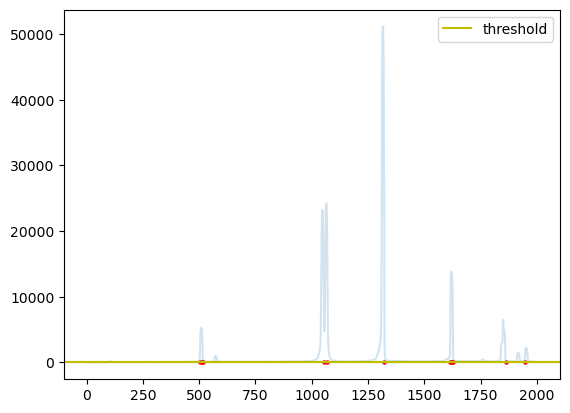

In [270]:

fig, ax = subplots()
ax.scatter(*zip(*peaks), c='r', s=5)
# ax.plot(excluded_data, alpha=0.)
ax.plot(raw, alpha=0.2)
ax.axhline(y=threshold, color='y', label='threshold')
ax.axhline(y=-threshold, color='y')
ax.legend()
show()
close(fig)

In [45]:
def process_peaks(raw_data, smoothed=True, deriv_count=2, thres_percent=1.5, power=3, normalise=True):
    if smoothed:
        data = alsbaseline(raw_data, lam=100, remove=False, niter=2)
    else:
        data = raw_data

    if deriv_count > 0:
        derivative = deriv(data, deriv_count)
        derivative_adjusted = derivative**power
    else:
        derivative_adjusted = data
    if normalise:
        if np.abs(derivative_adjusted.max()) > np.abs(derivative_adjusted.min()):
            derivative_adjusted /= derivative_adjusted.max()
        else:
            derivative_adjusted /= derivative_adjusted.min()
    else:
        if np.abs(derivative_adjusted.max()) < np.abs(derivative_adjusted.min()):
            derivative_adjusted *= -1
            
    threshold = np.percentile(derivative_adjusted, thres_percent)
    excluded_data = exclude(derivative_adjusted, threshold)
    peaks = get_peak_locations(excluded_data)
    sorted_peaks = peaks.copy()
    sorted_peaks.sort(key=lambda x: x[1], reverse=True)
    print(sorted_peaks)
    
    norm_curv = data/data.max()
    
    fig, ax = subplots()
    fig.suptitle('Peakfinding visualisation')
    ax.set_xlabel('datapoint index')
    ax.set_ylabel('normalised intensity')
    ax.plot(norm_curv, alpha=0.7, linestyle='--', c='orange', label='input curve')
    ax.scatter(*zip(*peaks), c='r', s=5, label='peaks')
    ax.plot(derivative_adjusted, alpha=0.6, label='cubed derivative')
    ax.axhline(y=threshold, color='y', label='threshold')
    ax.axhline(y=-threshold, color='y')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.6)
    show()
    close(fig)
    return peaks

[(1312, 34874533.63381084), (1069, 1952497.4810799044), (1043, 1579536.6155847544), (1035, -385395.7923946042), (1077, -579957.8829673224), (1304, -4171361.8351943325), (1327, -5024184.985592529)]


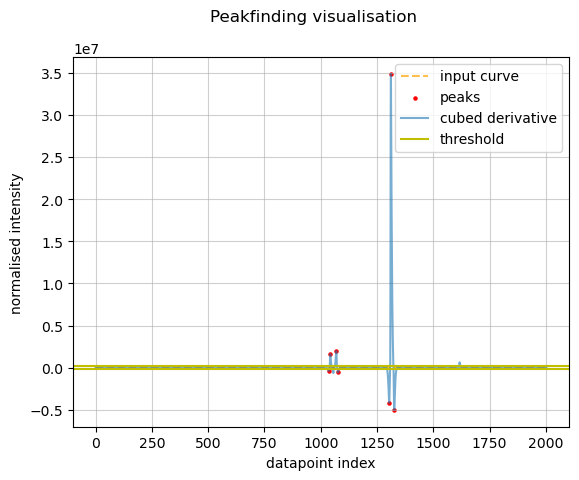

In [272]:
%matplotlib inline
peaks = process_peaks(raw, smoothed=True, thres_percent=2, normalise=False)
positive_peaks = [peak for peak in peaks if peak[1]>0]

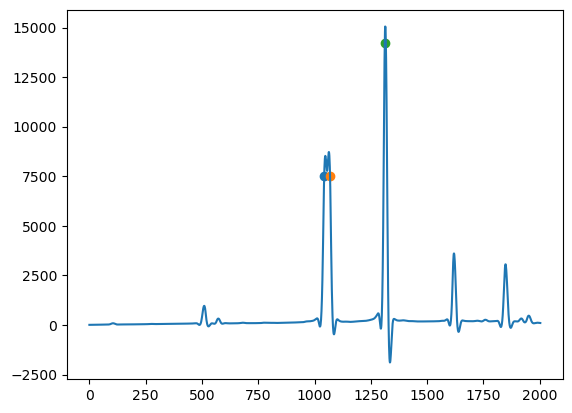

In [273]:
%matplotlib inline
fig, ax = subplots()
ax.plot(alsbaseline(raw, lam=100, remove=False, niter=2))
for x in emission_peak_locations:
    y = alsbaseline(raw, lam=100, remove=False, niter=2)[x]
    ax.scatter(x, y)
show()
close(fig)

In [274]:
# refine the peak location

print(emission_peak_locations)
window = 50
sec_left = [i-window for i in emission_peak_locations]
sec_right = [i+window for i in emission_peak_locations]
print(*list(zip(sec_left, sec_right)))
for i in range(len(emission_peak_locations)-1):
    l = sec_left[i+1]
    r = sec_right[i]
    print(l, r)
    if l < r:
        mid = (l+r)/2
        if mid%1 == 0:
            sec_left[i+1] = int(mid+1)
            sec_right[i] = int(mid)
        else:
            sec_left[i+1] = int(mid+1)
            sec_right[i] = int(mid)
           
sectors = list(zip(sec_left, sec_right))
print(sectors)

[1043, 1069, 1312]
(993, 1093) (1019, 1119) (1262, 1362)
1019 1093
1262 1119
[(993, 1056), (1057, 1119), (1262, 1362)]


In [275]:
# find max in sectors
final_peaks = []
for sector in sectors:
    l, r = sector
    print(l, r)
    peak = np.argmax(raw[l:r])+l, np.max(raw[l:r])
    final_peaks.append(peak)

993 1056
1057 1119
1262 1362


In [276]:
%matplotlib qt
fig, ax = subplots()
ax.plot(raw)
for peak in final_peaks:
    x, y = peak
    print(peak)
    ax.scatter(x, y, c='r')
show()
# close(fig)


(1048, 23180.683213581324)
(1065, 24222.842181957007)
(1316, 51154.30007389566)


In [75]:
def peak_functionality(name, data, smooth_data):
    fig, ax = subplots()
    ax.plot(raw, label=f'{name} data raw')
    ax.plot(smth, label=f'{name} data smoothed')
    ax.legend()
    ax.grid()
    show()
    close(fig)

    threshold = {'Arcturus':40, "Vega":4, "Regulus":2, "Moon":8}
    # arcturus: thresh_percent = 10 (for most visible peaks)
    # vega: thresh_percent = 4 (for 3 main peaks)
    # regulus: thresh_percent = 2
    # moon: thresh_percent = 2

    rough_peaks = process_peaks(smooth_data, thres_percent=threshold[name], smoothed=False)
    positive_peaks = [peak for peak in rough_peaks if peak[1]>0]



    fig, ax = subplots()
    fig.suptitle(f'{name} data with peaks')
    ax.plot(data, c='y', alpha=0.6, label=f'{objs[ob]} raw data')
    for x, _ in positive_peaks:
        y = data[x]
        ax.scatter(x, y, s=20, c='r')
    ax.scatter(x, y, s=20, c='r', label='Peaks')
    ax.legend()
    ax.grid(alpha=0.6)
    ax.set_xlabel('datapoint index')
    ax.set_ylabel('intensity (counts)')
    show()
    close(fig)

In [76]:
def spectra_picker(index):
    if index == 0:
        raw = np.loadtxt('./Final_data/uncorrected/Arcturus.txt')
    elif index == 1:
        raw = np.loadtxt('./Final_data/uncorrected/Vega.txt')
    elif index == 2:
        raw = np.loadtxt('./Final_data/uncorrected/Regulus.txt')
    elif index == 3:
        raw = np.loadtxt('./Final_data/uncorrected/Moon.txt')
    else:
        raise IndexError
    return raw

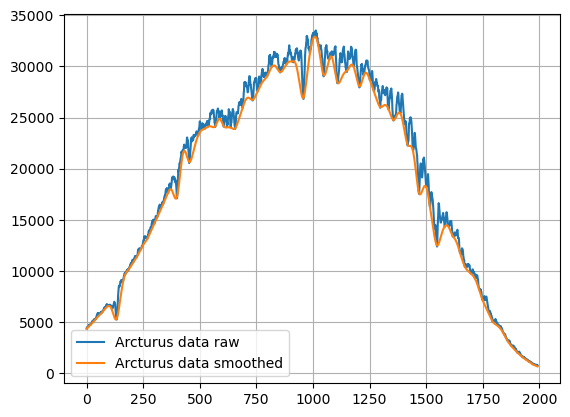

[(958, 1.0), (399, 0.6428682518322371), (1468, 0.6240615118608861), (1047, 0.43804466451561563), (133, 0.33515624708759745), (1548, 0.281838867276955), (1107, 0.25651987603509335), (1205, 0.23365176387177428), (453, 0.1768558885582357), (1417, 0.13668451329473044), (1355, 0.06048478987150126), (1297, 0.028177084907099248), (568, 0.025286327535646226), (656, 0.021994993959561424), (733, 0.015854645424963756), (855, 0.01394275447835611), (605, 0.01339717955160962), (1150, 0.00943051915015943), (1617, 0.00645572515187004), (1671, 0.002466892667836925), (798, 0.0021663046935645972), (1793, 0.0016644968257547958), (1748, 0.001206766967043166), (268, 0.0005659936855372196), (186, 0.00024210756383646784), (909, 0.0001935515206578618), (222, 0.00015221444183790574), (1858, 0.00014232975998696725), (522, 8.33132831356159e-05), (338, 3.63440862666578e-05), (354, -2.453947664948696e-05), (1825, -0.0001530336784702723), (246, -0.00018902129673100388), (631, -0.00019509311386881642), (543, -0.00023

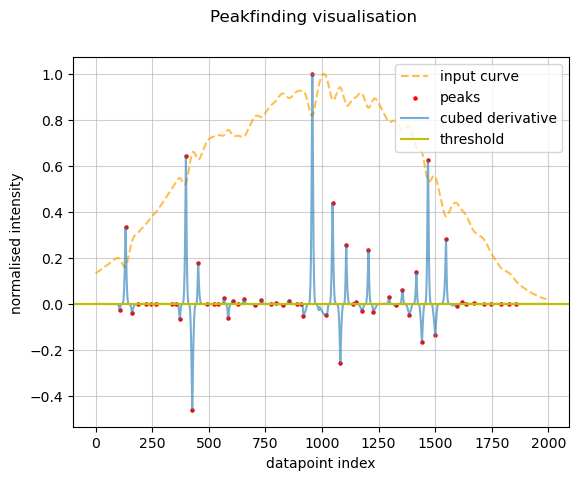

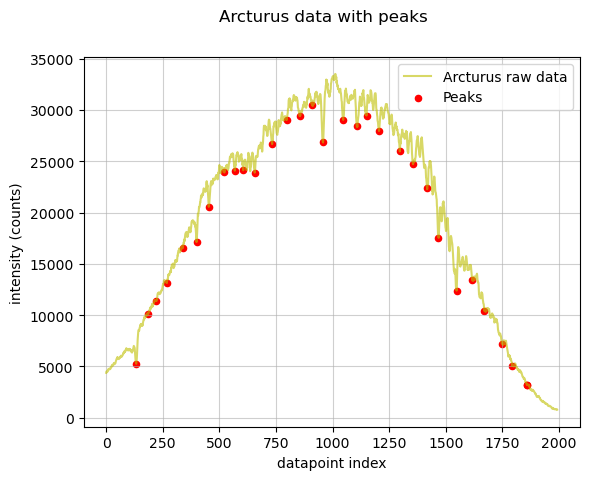

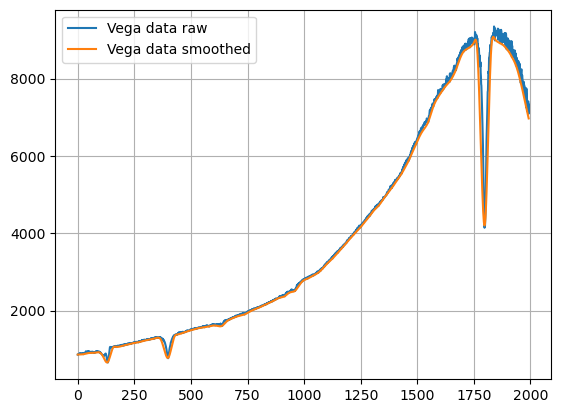

[(1798, 1.0), (399, 0.0015459792502403643), (133, 0.0007708537670221233), (365, -0.00023352166345055119), (156, -0.000435444356040145), (429, -0.0006038183352615436), (1764, -0.20402322996727174), (1826, -0.3380148825657869)]


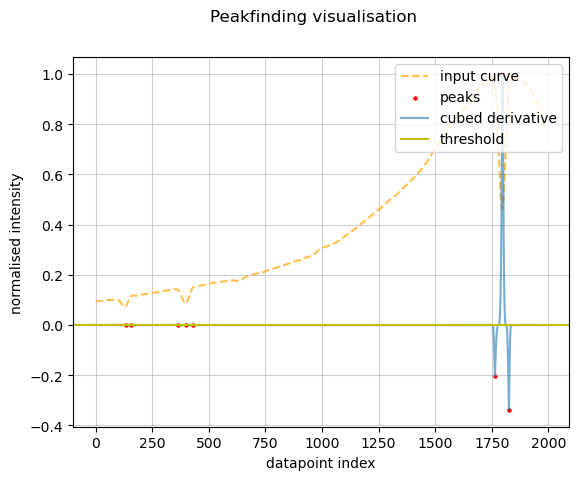

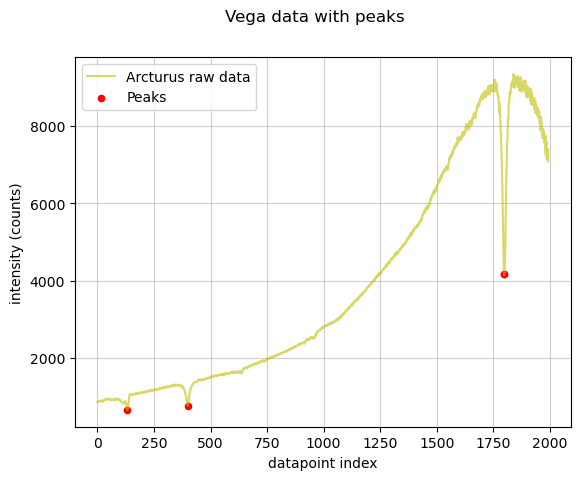

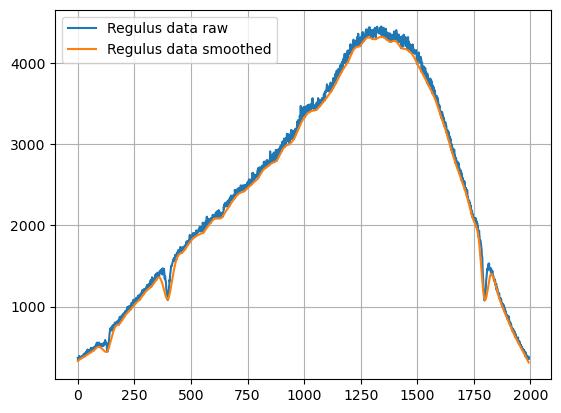

[(1797, 1.0), (398, 0.0984077341424091), (132, 0.015318963453577531), (360, -0.009025498556122703), (1825, -0.21542001439186928), (1771, -0.2584853009843504)]


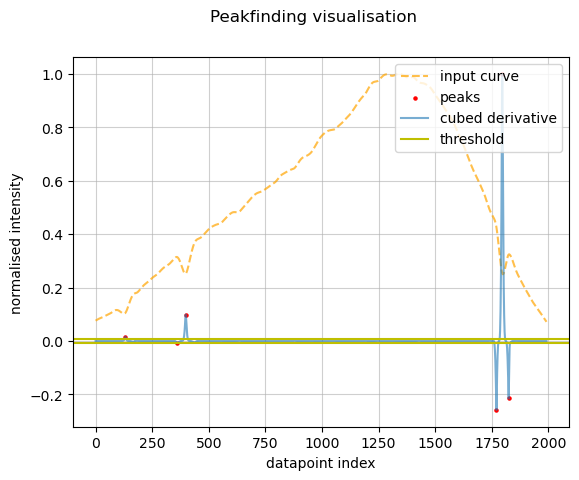

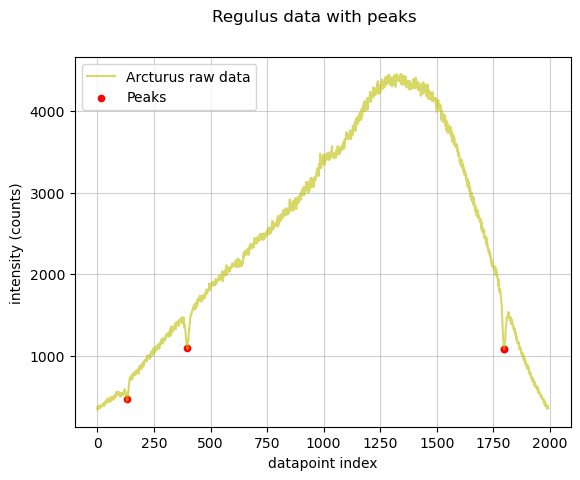

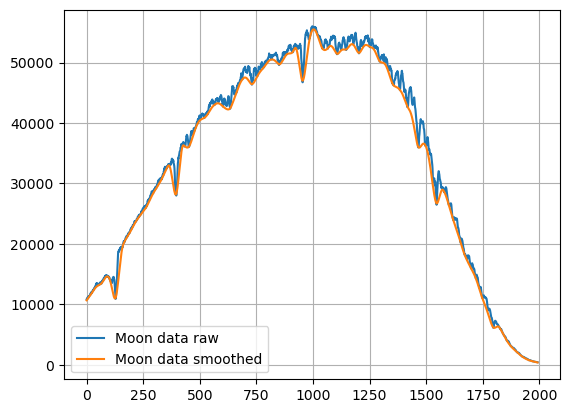

[(396, 1.0), (954, 0.6383212534573891), (128, 0.5756135064147742), (1546, 0.2567646603528924), (1464, 0.1108485383293026), (1203, 0.018209798282946835), (1107, 0.013094915466051526), (1797, 0.012043490921988769), (730, 0.01036531680142088), (1435, -0.006041307474214303), (1494, -0.012140908611645317), (985, -0.028551587472428364), (103, -0.029903040300278846), (1571, -0.07484685551285233), (157, -0.13936844529597742), (366, -0.1888309569269995), (925, -0.21498677158002713), (423, -0.5232883953507574)]


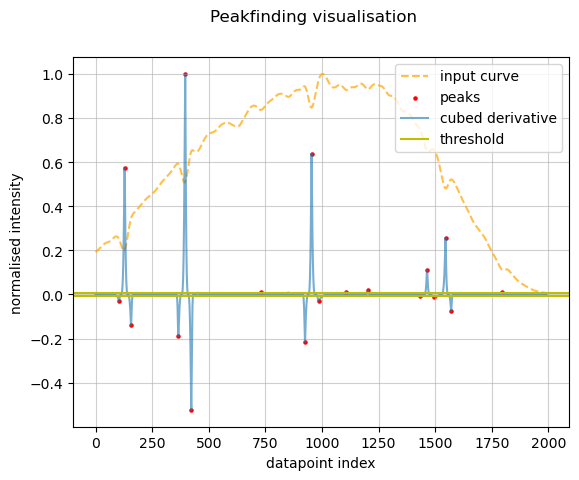

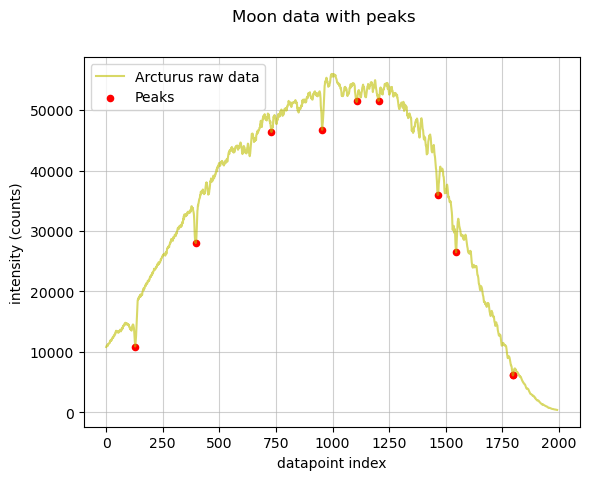

In [77]:
%matplotlib inline
objs = ['Arcturus', 'Vega', 'Regulus', 'Moon']
for i in range(4):
    raw = spectra_picker(i)
    smth = alsbaseline(raw, lam=50, niter=5, remove=False)
    peak_functionality(objs[i], raw, smth)